In [141]:
import pandas
import konlpy
import gensim
import matplotlib.pyplot as plt

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [142]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [143]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf
import os

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [82]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [83]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

In [84]:
# 3)-1 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


# 3)-2 적절한 최대 문장 길이 지정
# 최대 문장길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')




문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [85]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
from tensorflow.keras.preprocessing.sequence import pad_sequences

# pad_sequences를 활용한 패딩 추가
def pad_text_data(X_train, X_test, maxlen):
    # 패딩 추가 (앞쪽을 0으로 패딩)
    X_train_padded = pad_sequences(X_train, maxlen=maxlen, padding='pre', truncating='pre')
    X_test_padded = pad_sequences(X_test, maxlen=maxlen, padding='pre', truncating='pre')
    return X_train_padded, X_test_padded

# 패딩 적용
X_train, X_test = pad_text_data(X_train, X_test, maxlen)

# 결과 확인
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Example X_train:", X_train[0])

X_train shape: (146182, 41)
X_test shape: (49157, 41)
Example X_train: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4
  39 228  20  33 748]


### 4) 모델 구성 및 validation set 구성

### 4)-1 1D-CNN

In [86]:
import tensorflow as tf

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = tf.keras.Sequential([
    # Embedding 레이어
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_shape=(None,)),

    # Conv1D 레이어와 MaxPooling1D
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),

    # 추가 Conv1D 레이어
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),  # 전체 시퀀스에서 가장 큰 값을 선택

    # Dense layer
    tf.keras.layers.Dense(8, activation='relu'), #은닉층
    tf.keras.layers.Dense(1, activation='sigmoid') #출력층: 긍정1, 부정0
])
#모델 요약
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          1296      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          1296      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [87]:
# validation set 구성
import numpy as np

# validation set 10,000건 분리
X_val = np.array(X_train[:10000])
y_val = np.array(y_train[:10000])

# validation set을 제외한 나머지 15,000건
partial_X_train = np.array(X_train[10000:])
partial_y_train = np.array(y_train[10000:])

# 데이터의 shape 출력
print(partial_X_train.shape)  # (15000, sequence_length)
print(partial_y_train.shape)  # (15000,)

(136182, 41)
(136182,)


In [88]:
# 임베딩 레이어에서 trainable=False로 설정하여 학습되지 않도록 합니다.
model.layers[0].trainable = False  # Embedding 레이어 고정

# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20 # epochs=100

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 2s 5ms/step - loss: 0.6905 - accuracy: 0.5283 - val_loss: 0.6859 - val_accuracy: 0.5534
Epoch 2/20
266/266 [==============================] - 1s 4ms/step - loss: 0.6688 - accuracy: 0.5902 - val_loss: 0.6568 - val_accuracy: 0.6087
Epoch 3/20
266/266 [==============================] - 1s 4ms/step - loss: 0.6388 - accuracy: 0.6321 - val_loss: 0.6337 - val_accuracy: 0.6338
Epoch 4/20
266/266 [==============================] - 1s 4ms/step - loss: 0.6198 - accuracy: 0.6520 - val_loss: 0.6212 - val_accuracy: 0.6469
Epoch 5/20
266/266 [==============================] - 1s 4ms/step - loss: 0.6086 - accuracy: 0.6618 - val_loss: 0.6129 - val_accuracy: 0.6568
Epoch 6/20
266/266 [==============================] - 1s 4ms/step - loss: 0.6013 - accuracy: 0.6692 - val_loss: 0.6084 - val_accuracy: 0.6615
Epoch 7/20
266/266 [==============================] - 1s 4ms/step - loss: 0.5948 - accuracy: 0.6763 - val_loss: 0.6026 - val_accuracy: 0.6697
Epoch 

In [89]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5700 - accuracy: 0.6968
[0.570018470287323, 0.6968488693237305]


In [90]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


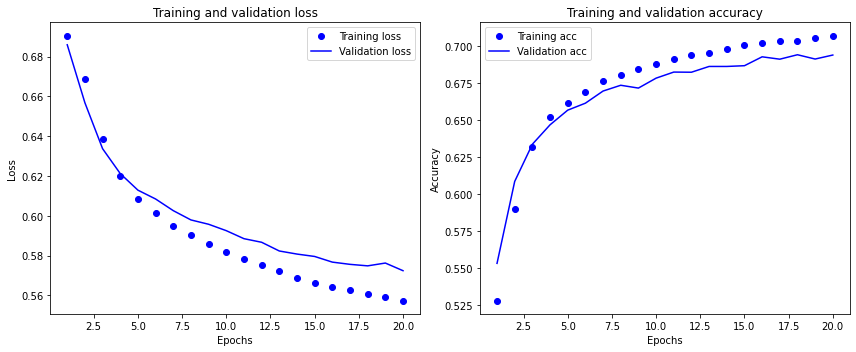

In [92]:
### 그래프
import matplotlib.pyplot as plt

# 데이터 준비
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 서브플롯 생성
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열의 서브플롯 생성, 크기 조정

# 첫 번째 서브플롯: Training and validation loss
axs[0].plot(epochs, loss, 'bo', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# 두 번째 서브플롯: Training and validation accuracy
axs[1].plot(epochs, acc, 'bo', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

### LSTM사용

In [93]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# 모델 설계 - LSTM 기반 모델
model = tf.keras.Sequential([
    # Embedding 레이어
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_shape=(None,)),
    
    # LSTM 레이어
    tf.keras.layers.LSTM(16, activation='tanh', return_sequences=False),  # LSTM 레이어
    
    # Dense layer
    tf.keras.layers.Dense(8, activation='relu'),  # 은닉층
    tf.keras.layers.Dense(1, activation='sigmoid')  # 출력층: 긍정1, 부정0
])


# Embedding 레이어 학습되지 않도록 설정
model.layers[0].trainable = False  # 임베딩 레이어 고정


#모델 요약
model.summary()


# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)




model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)






Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 162,257
Trainable params: 2,257
Non-trainable params: 160,000
_________________________________________________________________
(136182, 41)
(136182,)
Epoch 1/20
266/266 [==============================] - 3s 6ms/step - loss: 0.6855 - accuracy: 0.5501 - val_loss: 0.6808 - val_accuracy: 0.5527
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.6

In [94]:
# 평가 지표
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.6230 - accuracy: 0.6435
[0.6229916214942932, 0.6435298919677734]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Figure size 432x288 with 0 Axes>

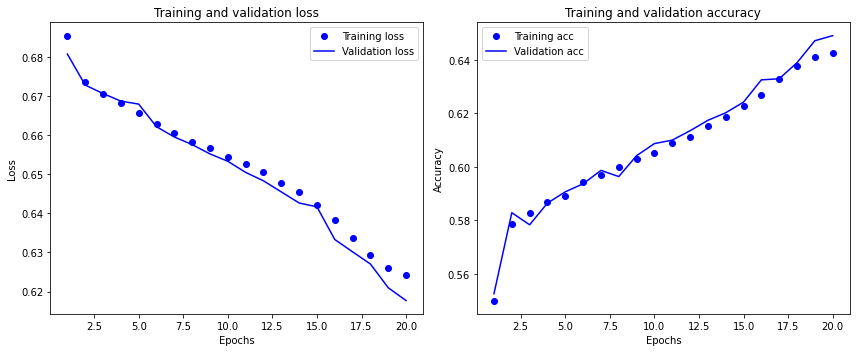

In [95]:
### 그래프 그리기
plt.clf() # 앞서 그린 그래프 지우기
# 데이터 준비
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 서브플롯 생성
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열의 서브플롯 생성, 크기 조정

# 첫 번째 서브플롯: Training and validation loss
axs[0].plot(epochs, loss, 'bo', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# 두 번째 서브플롯: Training and validation accuracy
axs[1].plot(epochs, acc, 'bo', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

#### Transformer 방식

In [96]:
import tensorflow as tf

# 하이퍼파라미터 설정
vocab_size = 10000    # 어휘 사전의 크기입니다 (10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수
num_heads = 4         # Multi-Head Attention의 헤드 수
ffn_dim = 32          # Feed-Forward Network의 은닉층 차원
num_layers = 2        # Transformer 블록의 수

# Positional Encoding
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, maxlen, d_model):
        super().__init__()
        self.pos_encoding = self._positional_encoding(maxlen, d_model)
    
    def _positional_encoding(self, maxlen, d_model):
        positions = tf.range(maxlen, dtype=tf.float32)[:, tf.newaxis]  # (maxlen, 1)
        dimensions = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]  # (1, d_model)

        # angle_rates 계산
        angle_rates = 1 / tf.pow(10000, (2 * (dimensions // 2)) / tf.cast(d_model, tf.float32))
        angle_rads = positions * angle_rates  # (maxlen, d_model)

        # sin과 cos 함수를 적용하여 positional encoding 생성
        pos_encoding = tf.concat([tf.sin(angle_rads), tf.cos(angle_rads)], axis=-1)  # (maxlen, d_model*2)

        # 만약 d_model이 16이 아니라면, pos_encoding의 차원을 d_model에 맞게 조정
        pos_encoding = pos_encoding[:, :d_model]  # (maxlen, d_model)

        return pos_encoding

    def call(self, x):
        # x에 pos_encoding을 더할 때 배치 차원을 고려한 브로드캐스팅
        return x + self.pos_encoding[:tf.shape(x)[1], :]

# Transformer 블록 정의
def transformer_block(inputs, num_heads, ffn_dim, dropout_rate=0.1):
    # Multi-Head Attention
    attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = tf.keras.layers.Dropout(dropout_rate)(attention_output)
    attention_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed-Forward Network
    ffn_output = tf.keras.layers.Dense(ffn_dim, activation='relu')(attention_output)
    ffn_output = tf.keras.layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)
    output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)
    
    return output

# 모델 설계 - Transformer 기반 모델
inputs = tf.keras.Input(shape=(None,))  # 입력 시퀀스
embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim)(inputs)



# Embedding 레이어를 학습되지 않도록 고정
embedding.trainable = False  # Embedding 레이어 고정


# Positional Encoding 추가
maxlen = 41  # 최대 시퀀스 길이
pos_encoding = PositionalEncoding(maxlen, word_vector_dim)(embedding)

x = pos_encoding
for _ in range(num_layers):
    x = transformer_block(x, num_heads=num_heads, ffn_dim=ffn_dim)

# 출력층
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# 모델 요약
model.summary()

# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

# 모델 컴파일 및 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 학습
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 16)     160000      input_3[0][0]                    
__________________________________________________________________________________________________
positional_encoding_2 (Position (None, None, 16)     0           embedding_8[0][0]                
__________________________________________________________________________________________________
multi_head_attention_2 (MultiHe (None, None, 16)     4304        positional_encoding_2[0][0]      
                                                                 positional_encoding_2[0][0]

In [97]:
# 평가 지표
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1537/1537 - 5s - loss: 0.5031 - accuracy: 0.8264
[0.5031185746192932, 0.8264336585998535]


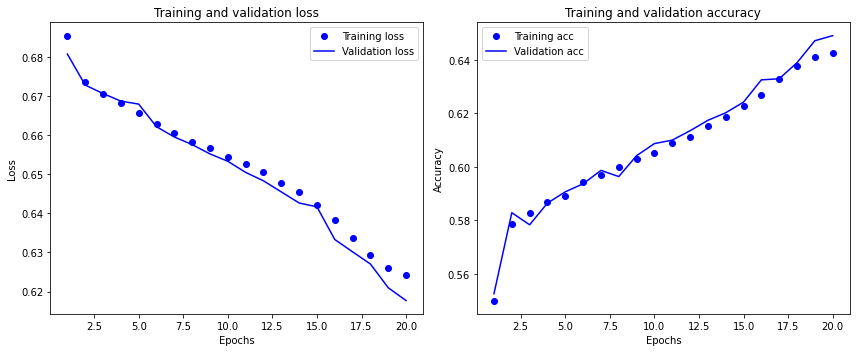

In [98]:
# 그래프 비교 
# 데이터 준비
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 서브플롯 생성

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열의 서브플롯 생성, 크기 조정

# 첫 번째 서브플롯: Training and validation loss
axs[0].plot(epochs, loss, 'bo', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# 두 번째 서브플롯: Training and validation accuracy
axs[1].plot(epochs, acc, 'bo', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

### 학습된 임베딩 레이어 분석

In [99]:
!mkdir -p ~/aiffel/sentiment_classification/data
!pip list | grep gensim

gensim                        4.1.2


In [100]:
# embedding_layer = model.layers[0]
# weights = embedding_layer.get_weights()[0]
# print(weights.shape)    # shape: (vocab_size, embedding_dim)


# Embedding 레이어 확인
embedding_layer = model.layers[1]  # 모델의 두 번째 레이어: Embedding 레이어 
print(f"Embedding layer: {embedding_layer}")

# 가중치 확인
weights = embedding_layer.get_weights()

# 가중치가 있는지 확인
if weights:
    print(f"Embedding weights shape: {weights[0].shape}")
else:
    print("Embedding weights are not available yet.")

Embedding layer: <keras.layers.embeddings.Embedding object at 0x7f7ece0144c0>
Embedding weights shape: (10000, 16)


In [101]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

#### gensim에서 제공하는 패키지를 이용해, 임베딩 파라미터를 word vector로 활용

In [102]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)


# 단어 목록 확인
print(list(word_vectors.key_to_index.keys())[:10])  # 상위 10개 단어 출력

# vector = word_vectors['computer']
# vector

['.', '영화', '다', '고', '하', '을', '보', '..', '게', ',']


#### 비슷한 단어 유사도 확인

In [103]:
word_vectors.similar_by_word("영화")

[('수다', 0.8912362456321716),
 ('봉', 0.8588735461235046),
 ('느낌', 0.8477964401245117),
 ('준다', 0.8371030688285828),
 ('던', 0.8326224088668823),
 ('닼', 0.8276500701904297),
 ('습니다', 0.8140498995780945),
 ('여러모로', 0.8043016195297241),
 ('스타일', 0.8004488945007324),
 ('만세', 0.7980656623840332)]

### 한국어 Word2Vec

In [104]:
!ln -s ~/data/word2vec_ko.model ~/aiffel/sentiment_classification/data
!ln -s ~/data/word2vec_ko.model.trainables.syn1neg.npy ~/aiffel/sentiment_classification/data
!ln -s ~/data//word2vec_ko.model.wv.vectors.npy ~/aiffel/sentiment_classification/data

ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/word2vec_ko.model': File exists
ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/word2vec_ko.model.trainables.syn1neg.npy': File exists
ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/word2vec_ko.model.wv.vectors.npy': File exists


In [105]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [125]:
# from gensim.models import Word2Vec
# import numpy as np

# # Word2Vec 모델 로드
# model = Word2Vec.load('word2vec_ko.model')

# # KeyedVectors 객체로 변환
# word_vectors = model.wv  # 'wv' 속성에서 KeyedVectors 객체로 접근

# embedding_matrix 크기 설정
vocab_size = 10000  # 어휘 사전 크기
word_vector_dim = 300  # 워드 벡터 차원 수 (예시로 300으로 설정)
embedding_matrix = np.zeros((vocab_size, word_vector_dim))

# index_to_word가 있다고 가정하고, 단어 벡터를 가져옴
for i in range(4, vocab_size):  # index_to_word의 인덱스를 사용할 때 범위 설정
    word = index_to_word[i]
    if word in vector:  # 단어가 KeyedVectors에 있는지 확인
        embedding_matrix[i] = word_vectors[word]
    else:
        # 단어가 vector에 없는 경우
        embedding_matrix[i] = np.zeros(word_vector_dim)

# embedding_matrix에 대한 확인
print(embedding_matrix.shape)

(10000, 300)


/tmp/ipykernel_33/3499252412.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if word in vector:  # 단어가 KeyedVectors에 있는지 확인


### 한국어 Word2Vec이 임베딩된 상태에서 1D-CNN으로 모델 학습

In [122]:
### 1d-cnn

from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                

In [124]:
# 학습의 진행
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 3s 7ms/step - loss: 0.6931 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 2/20
266/266 [==============================] - 2s 7ms/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 3/20
266/266 [==============================] - 2s 7ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 4/20
266/266 [==============================] - 2s 7ms/step - loss: 0.6931 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 5/20
266/266 [==============================] - 2s 7ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 6/20
266/266 [==============================] - 2s 7ms/step - loss: 0.6931 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.4973
Epoch 7/20
266/266 [==============================] - 2s 7ms/step - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 

In [109]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6932 - accuracy: 0.4973
[0.6931906938552856, 0.4973045587539673]


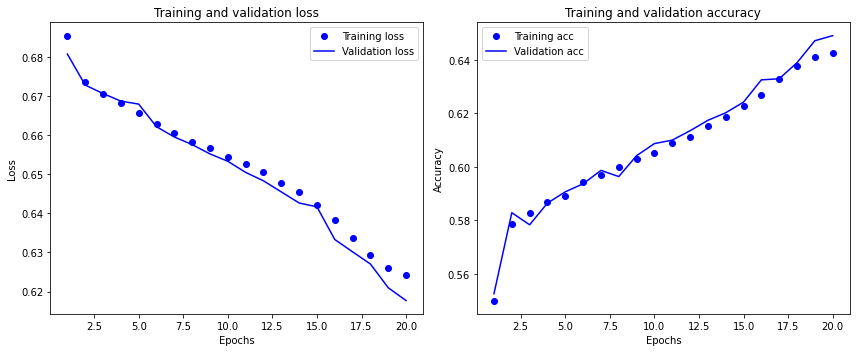

In [110]:
# 그래프 비교 
# 데이터 준비
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 서브플롯 생성

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열의 서브플롯 생성, 크기 조정

# 첫 번째 서브플롯: Training and validation loss
axs[0].plot(epochs, loss, 'bo', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# 두 번째 서브플롯: Training and validation accuracy
axs[1].plot(epochs, acc, 'bo', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

### 한국어 Word2Vec이 임베딩된 상태에서 LSTM

In [111]:
import numpy as np
import tensorflow as tf

# 임베딩 행렬 (Word2Vec 임베딩을 사용한다고 가정)
# embedding_matrix = np.random.rand(vocab_size, word_vector_dim)  # 예시로 랜덤 행렬을 사용

# 모델 설계 - Word2Vec 임베딩을 사용한 LSTM 기반 모델
model = tf.keras.Sequential([
    # Word2Vec 임베딩 행렬을 고정시키거나 훈련 가능하게 설정
    tf.keras.layers.Embedding(input_dim=vocab_size, 
                              output_dim=word_vector_dim, 
                              input_length=None,  # 시퀀스 길이는 None으로 설정
                              weights=[embedding_matrix],  # 사전 훈련된 임베딩 행렬 사용
                              trainable=False),  # 훈련되지 않도록 설정 (True로 바꾸면 학습됨)
    
    # LSTM 레이어
    tf.keras.layers.LSTM(16, activation='tanh', return_sequences=False),
    
    # Dense layer
    tf.keras.layers.Dense(8, activation='relu'),  # 은닉층
    tf.keras.layers.Dense(1, activation='sigmoid')  # 출력층: 긍정1, 부정0
])

# 모델 요약
model.summary()

# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# 모델 학습
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)




Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                20288     
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 3,020,433
Trainable params: 20,433
Non-trainable params: 3,000,000
_________________________________________________________________
(136182, 41)
(136182,)
Epoch 1/20
266/266 [==============================] - 3s 6ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss

In [112]:
# 평가
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

# 학습 결과 출력
history_dict = history.history
print(history_dict.keys())  # epoch에 따른 그래프를 그릴 수 있는 항목들

1537/1537 - 3s - loss: 0.6931 - accuracy: 0.4973
[0.6931493282318115, 0.4973045587539673]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


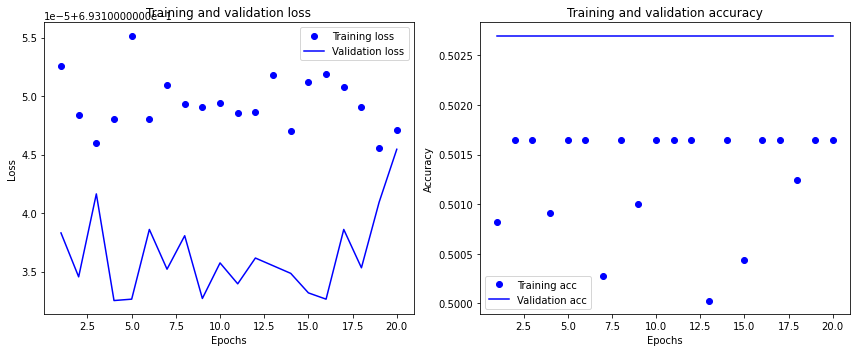

In [113]:
# 그래프 비교 
# 데이터 준비
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 서브플롯 생성

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열의 서브플롯 생성, 크기 조정

# 첫 번째 서브플롯: Training and validation loss
axs[0].plot(epochs, loss, 'bo', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# 두 번째 서브플롯: Training and validation accuracy
axs[1].plot(epochs, acc, 'bo', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

### 한국어 Word2Vec을 임베딩하여 GlobalMaxPooling1D

In [138]:


# 하이퍼파라미터 설정
vocab_size = 10000      # 어휘 사전 크기
word_vector_dim = 300   # 워드 벡터 차원 (예시로 300으로 설정)
max_sequence_length = 41  # 시퀀스 최대 길이 (예시로 41로 설정)

# 임베딩 매트릭스 예시 (여기서는 랜덤으로 생성, 실제로는 사전 학습된 워드2벡터를 사용)
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)  # 실제 임베딩 매트릭스를 사용하세요.

# 모델 설계 - GlobalMaxPooling1D를 사용한 모델
model = tf.keras.Sequential([
    # Embedding 레이어: 사전 학습된 임베딩 매트릭스를 사용하여 초기화
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=word_vector_dim,
                              weights=[embedding_matrix],  # 여기서 embedding_matrix를 사용
                              input_length=max_sequence_length,
                              trainable=False),  # 학습되지 않도록 설정 (사전 학습된 값 고정)
    
    # GlobalMaxPooling1D 레이어
    tf.keras.layers.GlobalMaxPooling1D(),  # 시퀀스에서 최대값을 추출
    
    # Dense 레이어 (은닉층)
    tf.keras.layers.Dense(16, activation='relu'),
    
    # 출력층
    tf.keras.layers.Dense(1, activation='sigmoid')  # 긍정(1)과 부정(0) 분류
])

# 모델 요약
model.summary()

# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 학습 (여기서는 예시 데이터 사용)
# X_train과 y_train은 훈련 데이터와 레이블
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)



Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 41, 300)           3000000   
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 300)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 16)                4816      
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 17        
Total params: 3,004,833
Trainable params: 4,833
Non-trainable params: 3,000,000
_________________________________________________________________
Epoch 1/10
4569/4569 [==============================] - 11s 2ms/step - loss: 0.6903 - accuracy: 0.5286 - val_loss: 0.6780 - val_accuracy: 0.6278
Epoch 2/10
4569/4569 [==============================] - 10s 2ms/step - loss: 0.6697 - accura

In [ ]:
# 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

In [ ]:
# 데이터 준비
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 서브플롯 생성

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열의 서브플롯 생성, 크기 조정

# 첫 번째 서브플롯: Training and validation loss
axs[0].plot(epochs, loss, 'bo', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# 두 번째 서브플롯: Training and validation accuracy
axs[1].plot(epochs, acc, 'bo', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

### 회고
여러번 모델을 학습시킬때 앞서 학습했던 정보가 계속 남아있지 않게 설정을 해줬어야 했는데
초반에 그러지 못해 결과가 이상하게 하게 나왔었다. 잘 기억해둬야겠다.
그리고 트랜스포머 모델에 대해 좀더 공부를 해야겠다.

### 앞으로 더 공부할 점: 한국어 Word2Vec를 임베딩해서 모델을 학습했는에 왜 정확도가 더 떨어질까???